In [234]:
import pandas as pd
import numpy as np
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pch
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from itertools import cycle

In [235]:
csv_str = """
Feature,Row Index 1,Row Index 2,Row Index 3,Row Index 4,Column Index 1,Sample 1,Sample 2,Sample 3,Sample 4
Feature 1,A,B,B,D,1,10.2,14.4,12.4,10.4
Feature 2,B,C,C,A,1,11.3,13.2,10.2,15.2
Feature 3,A,A,A,C,1,10.2,12.1,10.1,14.4
Feature 4,D,C,C,B,1,14.9,11.7,11.7,11.7
Feature 5,E,C,C,B,1,14.9,10.7,10.7,10.7
Feature 6,F,A,A,A,1,17.9,14.7,11.7,11.7
"""

In [236]:
# df = pd.read_csv(path / 'example.csv')
df = pd.read_csv(io.StringIO(csv_str))
df

,Feature,Row Index 1,Row Index 2,Row Index 3,Row Index 4,Column Index 1,Sample 1,Sample 2,Sample 3,Sample 4
0,Feature 1,A,B,B,D,1,10.2,14.4,12.4,10.4
1,Feature 2,B,C,C,A,1,11.3,13.2,10.2,15.2
2,Feature 3,A,A,A,C,1,10.2,12.1,10.1,14.4
3,Feature 4,D,C,C,B,1,14.9,11.7,11.7,11.7
4,Feature 5,E,C,C,B,1,14.9,10.7,10.7,10.7
5,Feature 6,F,A,A,A,1,17.9,14.7,11.7,11.7


In [237]:
def multi_index_heatmap(df, feature_column_name, row_index_columns, sample_columns, 
    feature_names_width=1.2, scale=1.0, unit=1., space=0.02, legend_offset=0.5, 
    heatmap_cell_width=1.5, heatmap_padding=0.1, colorbar_width=0.5, colorbar_padding=0.):
    # Extract labels:
    row_labels = {index_name: np.sort(df[index_name].unique()) for index_name in row_index_columns}
    # column_labels = {index_name: np.sort(df[index_name].unique()) for index_name in column_index_columns}
    # Specify GridSpec:
    widths = np.array(
        [unit*feature_names_width] + [unit] * len(row_labels) + 
        [unit*heatmap_padding] + 
        [unit*heatmap_cell_width] * len(sample_columns) + 
        [unit*colorbar_width])
    heights = np.array([unit] * (len(df) + 1) + [legend_offset*unit])
    gs_kw = dict(width_ratios=widths, height_ratios=heights)
    fig, axs = plt.subplots(
        ncols=len(widths), nrows=len(heights), subplot_kw=dict(frameon=False),
        constrained_layout=False, gridspec_kw=gs_kw, 
        figsize=(scale * widths.sum(), scale * heights.sum()))
    # Create a column for colorbar:
    gs = axs[1, -1].get_gridspec()
    for ax in axs[1:-1, -1]:
        ax.remove()
    axbig = fig.add_subplot(gs[1:-1, -1])
    # Find maximum value for samples
    np_sample = df[sample_columns].to_numpy()
    min_s, max_s = np_sample.min(), np_sample.max()
    # Define color mappings:
    ## Categorical:
    from matplotlib.cm import get_cmap
    cmaps = cycle(['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', ])
    def map_disc_(items, cmap_name):
        cmap_ = get_cmap(cmap_name)
        inter_ = 0.3
        slope_ = (1. - inter_) / len(items)
        return {value: cmap_(inter_ + items.tolist().index(value) * slope_) for value in items}
    row_colors = {label: map_disc_(items, cmap_name) \
        for (label, items), cmap_name in zip(row_labels.items(), cmaps)}
    # column_colors = {label: map_disc_(items, cmap_name) \
        # for (label, items), cmap_name in zip(column_labels.items(), cmaps)}
    ## Continuous:
    def lin_cmap_(inter, value, min_value, max_value):
        return inter + (value - min_value) * ((1. - inter) / np.abs(max_value - min_value))
    newgreys_ = lambda x: get_cmap('Greys')(lin_cmap_(0.2, x, min_s, max_s))
    newgreys = ListedColormap(newgreys_(np.linspace(min_s, max_s, 256)))
    # Apply settings for axes:
    for r, row in enumerate(axs):
        for c, ax in enumerate(row):
            ax.set(xticks=[], yticks=[])
            for _, spine in ax.spines.items():
                spine.set_visible(False)
            if r == len(axs) - 1:
                ax.patch.set_alpha(0.)
                continue
            if r >= 1 and c == 0:
                ax.text(0, 0.5, df[feature_column_name][r - 1], 
                    verticalalignment='center')
            if r == 0 and c > len(row_labels) + 1 and c < (len(row_labels) + 1 + len(sample_columns) + 1):
                ax.text(0.5, 0.5, sample_columns[c - len(row_labels) - 2], 
                    verticalalignment='center', horizontalalignment='center')
            if r >= 1 and c >= 1 and c < len(row_labels) + 1:
                var_name = list(row_labels.keys())[c - 1]
                var_value = df[var_name][r - 1]
                ax.add_patch(pch.Rectangle((0., 0.), 1., 1., 
                    facecolor=row_colors[var_name][var_value], edgecolor='none', label=var_value))
            elif r >= 1 and c >= 1 and c > len(row_labels) + 1 and c < (len(row_labels) + 1 + len(sample_columns) + 1):
                cmap = get_cmap('Greys')
                ax.patch.set_alpha(0.)
                var_name = sample_columns[c - len(row_labels) - 2]
                var_value = df[var_name][r - 1]
                ax.add_patch(pch.Rectangle((0., 0.), 1., 1., 
                    facecolor=newgreys_(var_value), edgecolor='none'))
    # Build the legend:
    sizes = [ll.shape[0] for ln, ll in row_labels.items()]
    largest_label_inx = np.argmax(sizes)
    ## Categorical variables:
    hndl = []
    for i, (lbl, colors_) in enumerate(row_colors.items()):
        size, empty = len(colors_), []
        if i >= 1:
            m = sizes[largest_label_inx] - sizes[i - 1]
            if m > 0:
                empty = [Line2D([], [], label='', alpha=0.)] * m
        hndl += empty + [Line2D([], [], label=lbl, alpha=0.)] + [
            pch.Patch(facecolor=color, edgecolor="k", label=label, alpha=0.7) 
            for label, color in colors_.items()
        ]
    hndl += [Line2D([], [], label='', alpha=0.)] * (sizes[largest_label_inx] - sizes[i])
    ## Continuous variables:
    fig.colorbar(ScalarMappable(
        norm=mpl.colors.Normalize(vmin=min_s, vmax=max_s), 
        cmap=newgreys), cax=axbig)
    legend = fig.legend(handles=hndl, loc='lower center', 
        handlelength=scale*1.4, handleheight=scale*1.6, 
        ncol=len(row_index_columns), labelspacing=.0)
    legend.get_frame().set_alpha(0.)
    plt.subplots_adjust(hspace=space, wspace=space)
    return fig

# Demo

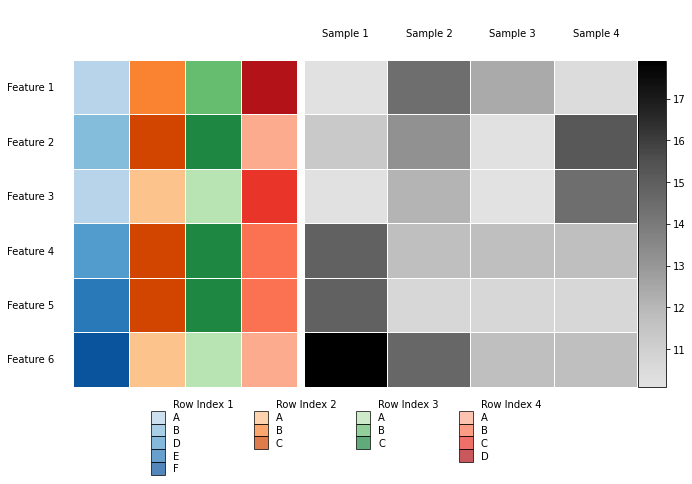

In [238]:
fig = multi_index_heatmap(df,
    feature_column_name='Feature', 
    row_index_columns=['Row Index 1', 'Row Index 2', 'Row Index 3', 'Row Index 4'], 
    sample_columns=['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4'])

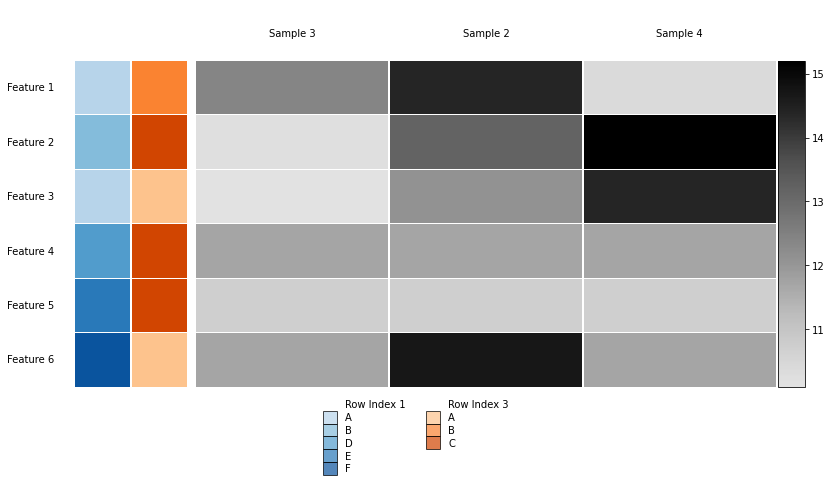

In [239]:
fig = multi_index_heatmap(df,
    feature_column_name='Feature', 
    row_index_columns=['Row Index 1', 'Row Index 3'], 
    sample_columns=['Sample 3', 'Sample 2', 'Sample 4'],
    heatmap_cell_width=3.5)

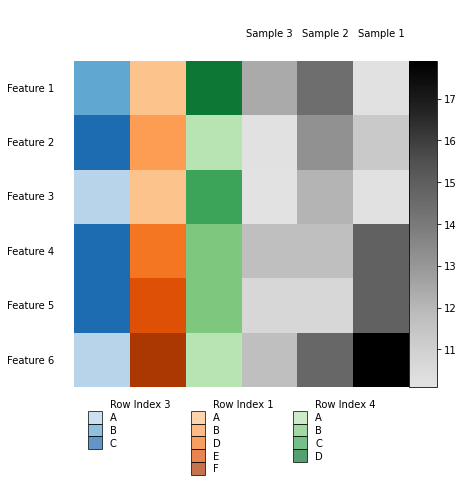

In [240]:
fig = multi_index_heatmap(df,
    feature_column_name='Feature', 
    row_index_columns=['Row Index 3', 'Row Index 1', 'Row Index 4'], 
    sample_columns=['Sample 3', 'Sample 2', 'Sample 1'],
    heatmap_cell_width=1.0, space=0., heatmap_padding=0.)